In [ ]:
##### Fig. 4 - Transfer of phonemic and prosodic representations along ventral and dorsal streams
#
# written by S-C. Baek
# updated date: 16.12.2024
#

In [1]:
# import packages
import os
import sys
import pickle

import numpy as np
import pandas as pd

from mne.stats.multi_comp import fdr_correction

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# path settings
FIGDIR  = os.getcwd()
MAINDIR = os.path.abspath('..')
DATADIR = MAINDIR + os.sep + 'data/'
PYDIR   = MAINDIR + os.sep + 'code' + os.sep + 'python/'

In [3]:
# subjects
s = os.listdir(DATADIR)
subjects = [i for i in s if 'sub-' in i]
subjects.sort()
n_subjects = len(subjects)

In [4]:
# linguistic elements
elements = ['phoneme', 'prosody']
n_elements = len(elements)

In [ ]:
# Fig. 4b,c/e,f - Averaged mTEn and mean time lags of directed conntections for phonemes or prosody

In [5]:
# element to plot
ei = 0 # 0: phonemes, 1: prosody
element = elements[ei]

# get data configuration
fname = DATADIR + subjects[0] + os.sep + 'meg' + os.sep + 'mte_rois_' + element + '_norm.pickle'
with open(fname, 'rb') as f:
    tmp = pickle.load(f)
    
# reconstruct time lags
max_lag = tmp['max_lag']
lags = np.arange(1, max_lag+1)
n_lags = len(lags)

# connections
conn = [c for c in tmp.keys() if '_to_' in c]

# reconstruct the ROIs
rois_subset = []
for c in conn:
    rs = c.split('_to_')
    for r in rs:
        if not r in rois_subset:
            rois_subset.append(r)
rois_subset=list(set(rois_subset))
rois_subset.sort()

In [6]:
# import directed-connection-wise cluster statistics
fname = DATADIR + 'group' + os.sep + 'meg' + os.sep + 'mte_rois_' + element + '_mTEn_vs_0_p05.pickle'
with open(fname, 'rb') as f:
    cluster_stats_mte = pickle.load(f)
connections         = cluster_stats_mte['connections']
sig_clusters_uncorr = cluster_stats_mte['sig_clusters_uncorr']
sig_p_vals_uncorr   = cluster_stats_mte['sig_p_vals_uncorr']
del cluster_stats_mte

# make sure that the order or the connections is the same
for ca, cb in zip(conn, connections):
    assert ca == cb
del conn

In [7]:
# FDR correction based on the minimum p-value of each directed connection

# preparation for the correction
n_conn = len(connections)
assert n_conn == len(sig_clusters_uncorr)
assert n_conn == len(sig_p_vals_uncorr)
sig_clusters = list()
sig_p_vals = list()

# collect the minimum p-vals from all connections
pvals = list()
for ps in sig_p_vals_uncorr:
    pvals.append(min(ps)) if len(ps) > 0 else pvals.append(0.99)
assert len(pvals) == n_conn
reject, pvals_correct = fdr_correction(pvals) # apply FDR correction
factor = pvals_correct / pvals

# loop over connections to collect significant clusters and p-values after the correction
for i in range(n_conn):
    if reject[i]: # when there is a significant cluster after the correction
        # indices for significant clusters after the correction
        corr_p_vals = np.array(sig_p_vals_uncorr[i]) * factor[i]
        sig_inds = np.where( corr_p_vals < 0.05 )[0]
        
        # significant clusters after the corrections
        sig_clus_corr = [sig_clusters_uncorr[i][s] for s in sig_inds]
        sig_clusters.append(sig_clus_corr)
    
        # corresponding corrected p-values
        sig_pvals_corr = [corr_p_vals[s] for s in sig_inds]
        sig_p_vals.append(sig_pvals_corr)
    else: # when no significant clusters after the correction
        sig_clusters.append(list())
        sig_p_vals.append(list())
print( np.array(connections)[reject] )

['L-PAC_to_L-aSTS' 'L-PAC_to_L-pSTS' 'L-PAC_to_R-PAC' 'L-PAC_to_R-aSTS'
 'L-aSTS_to_L-PAC' 'L-aSTS_to_L-pSTS' 'L-aSTS_to_R-aSTS' 'L-pSTS_to_L-PAC'
 'L-pSTS_to_L-aSTS' 'L-pSTS_to_R-PAC' 'L-pSTS_to_R-aSTS'
 'L-pSTS_to_R-pSTS' 'R-PAC_to_L-PAC' 'R-PAC_to_L-aSTS' 'R-PAC_to_L-pSTS'
 'R-PAC_to_R-aSTS' 'R-PAC_to_R-pSTS' 'R-aSTS_to_L-aSTS' 'R-pSTS_to_L-PAC'
 'R-pSTS_to_L-aSTS' 'R-pSTS_to_L-pSTS' 'R-pSTS_to_R-PAC'
 'R-pSTS_to_R-aSTS']


Text(0.5, 1.0, 'mean sig. langs (ms)')

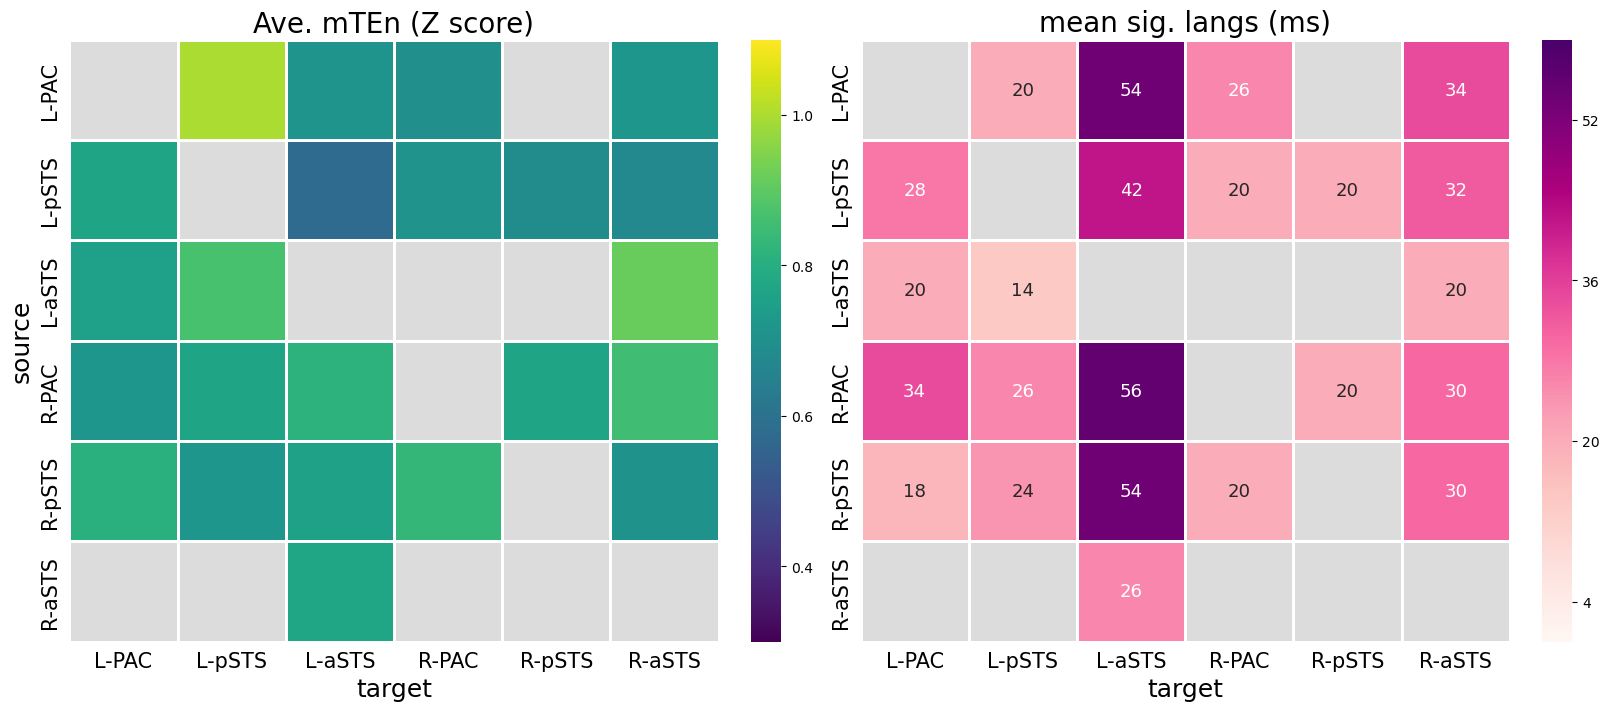

In [8]:
# plot connectivity matrices for different measurements 

# reconstruct the ROIs
n_rois_subset = len(rois_subset)
roi_inds = list(range(n_rois_subset))

# create a data frame to visualize the max cluster per each connections
mTE_mtx = np.zeros( (n_rois_subset, n_rois_subset) )
Lag_mtx = np.zeros( (n_rois_subset, n_rois_subset), dtype=int )

# loop over rois_subset indices
for i in roi_inds:
    for j in roi_inds[:i] + roi_inds[i+1:]:
        
        # specify a connection
        source = rois_subset[i]
        target = rois_subset[j]
        conn = source + '_to_' + target
        
        # index of the connection
        conn_idx = [c for c in range(len(connections)) if connections[c] == conn][0]
        
        # loop over subjects to collect testing data
        X = np.zeros( (n_lags, n_subjects) )
        for subi, subject in enumerate(subjects):
            
            # import individual data
            fname = DATADIR + subject + os.sep + 'meg' + os.sep + 'mte_rois_' + element + '_norm.pickle'
            with open(fname, 'rb') as f:
                mTEn = pickle.load(f)
            X[:,subi] = mTEn[conn] # n_lags X n_subjects
        mX = np.mean(X, axis=-1)
            
        # fill in the empty arrays
        if len(sig_p_vals[conn_idx]) > 0:
            
            # significant intervals
            sig_pnts = sig_clusters[conn_idx][0][0]
            
            # 1) averaged mTEn during the significant interval
            mTE_mtx[i,j] = np.mean(mX[sig_pnts]) # mean
            
            # 2) mean lag in ms during the significant interval
            Lag_mtx[i,j] = np.mean(lags[sig_pnts])*4 # mean lag
        del X, mX

# shuffle the order of rois
if element == 'phoneme':
    reorder = np.array([0, 2, 1,
                        3, 5, 4])
elif element == 'prosody':
    reorder = np.array([1, 0, 3, 2,
                        4, 6, 5, 8, 7])
mTE_mtx = mTE_mtx[reorder, :]
mTE_mtx = mTE_mtx[:, reorder]
Lag_mtx = Lag_mtx[reorder, :]
Lag_mtx = Lag_mtx[:, reorder]

# data into data frame
rois_subset = np.array(rois_subset)
nTE = pd.DataFrame(data=mTE_mtx, index=rois_subset[reorder], columns=rois_subset[reorder])
Lag = pd.DataFrame(data=Lag_mtx, index=rois_subset[reorder], columns=rois_subset[reorder])

# prepare mask for plotting significant connections
mask = np.zeros_like(nTE, dtype='bool') # make mask for upper triangle
mask[Lag_mtx<1] = True

# colormap
cmap1 = matplotlib.colormaps.get_cmap('viridis')
cmap1.set_bad("#DCDCDC")
cmap2 = matplotlib.colormaps.get_cmap('RdPu')
cmap2.set_bad("#DCDCDC")

# figure
fig, ax = plt.subplots(1,2, figsize=(16,7), constrained_layout=True)
sns.heatmap(data=nTE, vmin=0.3, vmax=1.1, cmap=cmap1, cbar_kws={'ticks':np.linspace(0.4, 1, 4)},
            linewidths=1, mask=mask, linecolor='w', ax=ax[0])
sns.heatmap(data=Lag, vmin=0, vmax=60, cmap=cmap2, cbar_kws={'ticks':np.arange(4,60,16)},
            linewidths=1, mask=mask, linecolor='w', ax=ax[1],
            annot=True, annot_kws={'fontsize':13})

# accessories
for i in range(2):
    ax[i].tick_params(axis='x', labelsize=15)
    ax[i].tick_params(axis='y', labelsize=15)
    for tick in ax[i].xaxis.get_major_ticks(): # x-axis
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    for tick in ax[i].yaxis.get_major_ticks(): # y-axis
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    ax[i].set_xlabel('target', fontsize=18)
    if i == 0:
        ax[i].set_ylabel('source', fontsize=18)
ax[0].set_title('Ave. mTEn (Z score)', fontsize=20)
ax[1].set_title('mean sig. langs (ms)', fontsize=20)